# CPSC 330 Lecture 19

Outline:

- 👋
- **Turn on recording**
- Announcements
- True/False questions from last time (10 min)
- Outliers: intro (10 min)
- Outlier scavenger hunt (20 min)
- Break (5 min)
- Mean vs median (5 min)
- Effect on trained models (20 min)
- Outlier scenarios (5 min)

Piazza:

- True/False questions


Reminder to self: **turn on recording!**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, IsolationForest

In [6]:
plt.style.use("seaborn")
plt.rcParams['font.size'] = 16

In [7]:
from pandas_profiling import ProfileReport

# TODO

- Need to train/test split - some of them thought this meant you didn't need to.
- There are 3 TODOs in the lecture itself below.

## Announcements

- First 9 minutes of Lecture 15 recording were corrupted
- hw6 released, due next Monday at 11:59pm
- Golden Rule violation in Lecture 13 - see https://piazza.com/class/kb2e6nwu3uj23?cid=440
- Midterm grades posted - see https://piazza.com/class/kb2e6nwu3uj23?cid=447
- This week we'll be talking about data involving time.


## Outliers intro (10 min)

#### What is an outlier?


- Loosely speaking, an **outlier** is an observation that is very different from the others.
- These are also called **anomalies** is certain contexts.
- Let's take a look at these [CPSC 340 slides on outlier detection](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L10.pdf), section on "Global vs. Local Outliers".
- Keep in mind that we can have outliers in our features or in our targets (at least for regresson).

#### Why do we want to find outliers? 

Some main reasons are:

1. Data quality concerns. We want to **remove** the outliers.
2. Our task is actually to **find** (identify, detect) the outliers. E.g. credit card fraud.

Thus, outliers are not categorically good nor bad - it depends on the context.

#### How can we find outliers? Very high level overview.

- Most of outlier detection is unsupervised.
  - There are various approaches, today we'll consider looking at plots and summary statistics.
- But, remember our credit card fraud dataset? That was really supervised anomaly detection!
  - Find the unusual events (frauds) based on labelled data. 
  - Here, we could just use our regular supervised learning techniques.
  
Note: you can have both supervised and unsupervised cases where you want to find anomalies.

#### How can we guard against unwanted outliers?

There are two general strategies:

1. Remove outliers.
2. Use methods that are **robust** to outliers.

## Outlier scavenger hunt (15 min)

#### Census data (lectures 6-7)

In [24]:
df_census = pd.read_csv('data/adult.csv')
census_train, census_test = train_test_split(df_census, test_size=0.2, random_state=123)
census_train.head()

age     workclass  fnlwgt     education  education.num  \
17064   20       Private  110998  Some-college             10   
18434   22       Private  263670       HS-grad              9   
3294    51       Private  335997       HS-grad              9   
31317   53       Private  111939     Bachelors             13   
4770    52  Self-emp-inc   51048     Bachelors             13   

           marital.status       occupation relationship                race  \
17064       Never-married     Adm-clerical    Own-child  Asian-Pac-Islander   
18434       Never-married    Other-service    Own-child               Black   
3294   Married-civ-spouse  Exec-managerial      Husband               White   
31317  Married-civ-spouse    Other-service      Husband               White   
4770   Married-civ-spouse            Sales      Husband               White   

          sex  capital.gain  capital.loss  hours.per.week native.country  \
17064  Female             0             0              30  United-States   
18434    Male             0             0              80  United-States   
3294     Male          4386             0              55  United-States   
31317    Male             0             0              35  United-States   
4770     Male             0             0              55  United-States   

      income  
17064  <=50K  
18434  <=50K  
3294    >50K  
31317  <=50K  
4770   <=50K

In [92]:
census_train.shape

(32561, 15)

In [ ]:
profile_census = ProfileReport(census_train, minimal=True)

In [93]:
profile_census.to_notebook_iframe()

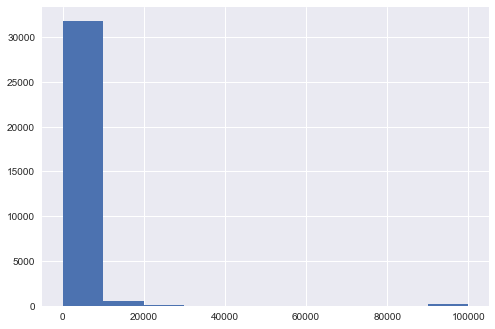

In [94]:
census_train["capital.gain"].hist();

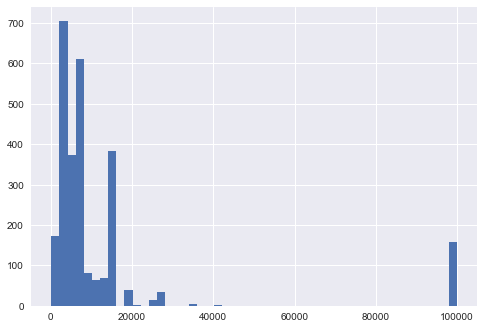

In [95]:
capital_gain = census_train["capital.gain"]
capital_gain[capital_gain > 0].hist(bins=50);

- It looks like we have a small number of individuals with a lot more capital gain than everyone else.
- Could those be outliers?

#### Isolation forests

- Another approach I heard about is isolation forests
- I haven't used these myself but here is the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)
- Conveniently built in to sklearn, we just need to do the feature preprocessing to get this to work:

In [47]:
numeric_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 
                    'capital.loss', 'hours.per.week']
categorical_features = ['workclass', 'marital.status', 'occupation', 
                        'relationship', 'race', 'sex', 'native.country']
target_column = 'income'
pipe_cat = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
census_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', pipe_cat, categorical_features)
])
census_preprocessor.fit(census_train);

In [48]:
census_columns = numeric_features + list(census_preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names(categorical_features))
census_train_enc = pd.DataFrame(census_preprocessor.transform(census_train), index=census_train.index, columns=census_columns)

In [49]:
isolation = IsolationForest()
predicted_outliers = isolation.fit_predict(census_train_enc) < 0

Above: from the documentation, `predict` returns +1 for inlier and -1 for outlier.

In [51]:
census_train_enc[predicted_outliers].head()

age    fnlwgt  education.num  capital.gain  capital.loss  \
25908  1.205185 -0.684510       2.305248     -0.146669     -0.216807   
13296  0.030349  1.053334      -2.748829     -0.146669     -0.216807   
30141 -0.924206 -0.558194       0.750147     -0.146669     -0.216807   
197    0.764621 -0.827351      -1.971278     -0.146669      5.302951   
21256 -0.703924  0.637928      -3.137604     -0.146669     -0.216807   

       hours.per.week  workclass_?  workclass_Federal-gov  \
25908        2.394831          0.0                    0.0   
13296       -0.845065          0.0                    0.0   
30141       -0.035091          0.0                    0.0   
197         -0.035091          0.0                    0.0   
21256       -0.035091          1.0                    0.0   

       workclass_Local-gov  workclass_Never-worked  ...  \
25908                  0.0                     0.0  ...   
13296                  0.0                     0.0  ...   
30141                  0.0                     0.0  ...   
197                    1.0                     0.0  ...   
21256                  0.0                     0.0  ...   

       native.country_Portugal  native.country_Puerto-Rico  \
25908                      0.0                         0.0   
13296                      0.0                         1.0   
30141                      0.0                         0.0   
197                        0.0                         0.0   
21256                      0.0                         0.0   

       native.country_Scotland  native.country_South  native.country_Taiwan  \
25908                      0.0                   0.0                    0.0   
13296                      0.0                   0.0                    0.0   
30141                      0.0                   0.0                    0.0   
197                        0.0                   0.0                    0.0   
21256                      0.0                   0.0                    0.0   

       native.country_Thailand  native.country_Trinadad&Tobago  \
25908                      0.0                             0.0   
13296                      0.0                             0.0   
30141                      0.0                             0.0   
197                        0.0                             0.0   
21256                      0.0                             0.0   

       native.country_United-States  native.country_Vietnam  \
25908                           0.0                     0.0   
13296                           0.0                     0.0   
30141                           0.0                     0.0   
197                             1.0                     0.0   
21256                           0.0                     0.0   

       native.country_Yugoslavia  
25908                        0.0  
13296                        0.0  
30141                        0.0  
197                          0.0  
21256                        0.0  

[5 rows x 92 columns]

- It found 61 outliers out of around 26,000 training examples.
- We can look at the capital gain of these cases for example:

In [52]:
census_train[predicted_outliers].head()

age  workclass  fnlwgt   education  education.num  \
25908   55  State-gov  117357   Doctorate             16   
13296   39    Private  299828     5th-6th              3   
30141   26    Private  130620  Assoc-acdm             12   
197     49  Local-gov  102359         9th              5   
21256   29          ?  256211     1st-4th              2   

              marital.status         occupation    relationship  \
25908     Married-civ-spouse     Prof-specialty         Husband   
13296              Separated              Sales       Unmarried   
30141  Married-spouse-absent       Craft-repair  Other-relative   
197                  Widowed  Handlers-cleaners       Unmarried   
21256          Never-married                  ?       Own-child   

                     race     sex  capital.gain  capital.loss  hours.per.week  \
25908  Asian-Pac-Islander    Male             0             0              70   
13296               Black  Female             0             0              30   
30141  Asian-Pac-Islander  Female             0             0              40   
197                 White    Male             0          2231              40   
21256  Asian-Pac-Islander    Male             0             0              40   

      native.country income  
25908              ?   >50K  
13296    Puerto-Rico  <=50K  
30141              ?  <=50K  
197    United-States   >50K  
21256    Philippines  <=50K

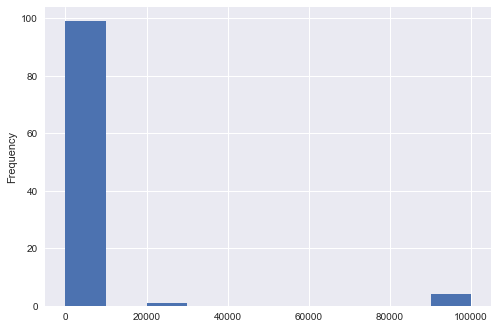

In [54]:
census_train.loc[predicted_outliers, "capital.gain"].plot.hist();

- We see lots of small (typical) values - it's not picking only based on capital gain here, but based on all the features.
- I don't know the details.

#### Movie review data (lectures 4-5)

In [96]:
df_imdb = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
df_imdb.head()

type                                             review label         file
0  test  Once again Mr. Costner has dragged out a movie...   neg      0_2.txt
1  test  This is an example of why the majority of acti...   neg  10000_4.txt
2  test  First of all I hate those moronic rappers, who...   neg  10001_1.txt
3  test  Not even the Beatles could write songs everyon...   neg  10002_3.txt
4  test  Brass pictures (movies is not a fitting word f...   neg  10003_3.txt

Let's look at a histogram of the lengths of reviews:

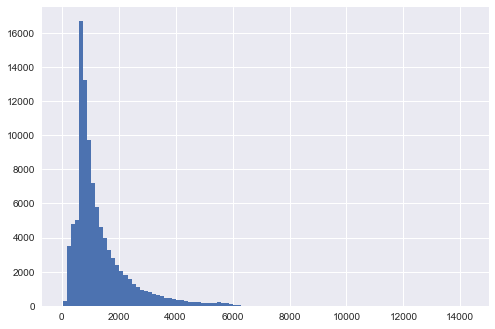

In [97]:
df_imdb["review"].apply(len).hist(bins=100);

In [98]:
df_imdb["review"].apply(len).max()

14282

Wow, that is a long review!

In [99]:
ind = df_imdb["review"].apply(len).argmax()
ind

56763

In [100]:
df_imdb["review"][ind]

'***SPOILERS*** ***SPOILERS*** The first Godzilla movie in the third movie series, whereas GODZILLA VS. DESTOROYAH, the previous entry, aptly ended the second series. What else can I say? Well, let\'s break it down.<br /><br />I once liked the 2nd series of Godzilla movies (1984-1995), even though I found something annoying about those movies (as either the bad or good guy, Godzilla was so sympathetic that the human characters came off as obnoxious). Then, in 1995, along came a movie called GAMERA: GUARDIAN OF THE UNIVERSE and its two successful sequels, all directed by master filmmaker Shuusuke Kaneko, who singlehandedly changed the face of Japanese monster movies forever. I was spoiled!!! The Series 2 Godzilla movies were suddenly looked down as half-hearted, heavy-handed, auto-piloted and lazy attempts at recreating the "original" Godzilla, and end up being an insult to the memory of genre masters Ishirou Honda and Eiji Tsuburaya. GAMERA 3: THE AWAKENING OF IRIS, released the same y

#### Amazon product ratings data (lecture 15)

In [101]:
df_ratings = pd.read_csv("data/ratings_Patio_Lawn_and_Garden.csv", names=("user","item","rating","timestamp"))
df_ratings

user        item  rating   timestamp
0       A2VNYWOPJ13AFP  0981850006     5.0  1259798400
1       A20DWVV8HML3AW  0981850006     5.0  1371081600
2       A3RVP3YBYYOPRH  0981850006     5.0  1257984000
3       A28XY55TP3Q90O  0981850006     5.0  1314144000
4       A3VZW1BGUQO0V3  0981850006     5.0  1308268800
...                ...         ...     ...         ...
993485  A2G7RZI15ZPCTH  B00LW2Z4NS     5.0  1405641600
993486  A2V247ZQT9OJIT  B00LW2Z4NS     5.0  1405900800
993487   AF30DHAVSYNZ0  B00LW2Z4NS     5.0  1405641600
993488  A34KTJ4VWNBOHI  B00LW2Z4NS     5.0  1405900800
993489   A4XPE5UGK51IA  B00LW2Z4NS     5.0  1405900800

[993490 rows x 4 columns]

Probably no outliers here, since ratings are from 1 to 5. But we might have "outlier" products or users in the sense of having given/received way more ratings than typical (see Lecture 15).

#### Rain in Australia data (next week)

In [10]:
df_rain = pd.read_csv("data/weatherAUS.csv")
df_rain.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  Pressure9am  \
0           W           44.0          W  ...        22.0       1007.7   
1         WNW           44.0        NNW  ...        25.0       1010.6   
2         WSW           46.0          W  ...        30.0       1007.6   
3          NE           24.0         SE  ...        16.0       1017.6   
4           W           41.0        ENE  ...        33.0       1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RISK_MM  \
0       1007.1       8.0       NaN     16.9     21.8         No      0.0   
1       1007.8       NaN       NaN     17.2     24.3         No      0.0   
2       1008.7       NaN       2.0     21.0     23.2         No      0.0   
3       1012.8       NaN       NaN     18.1     26.5         No      1.0   
4       1006.0       7.0       8.0     17.8     29.7         No      0.2   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 24 columns]

In [11]:
df_rain.shape

(142193, 24)

In [12]:
df_rain_subset = df_rain.query("Location == 'Sydney'")
df_rain_subset.shape

(3337, 24)

In [13]:
profile_rain_subset = ProfileReport(df_rain_subset, minimal=True)

In [14]:
profile_rain_subset.to_notebook_iframe()

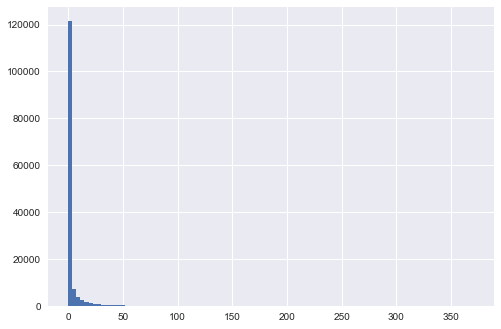

In [15]:
df_rain["Rainfall"].hist(bins=100);

In [16]:
df_rain["Rainfall"].max()

371.0

3.7 metres of rain in one day?!?

#### House price data (lecture 10-11)

In [17]:
df_housing = pd.read_csv("data/housing.csv")
df_housing

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

In [18]:
df_housing.shape

(1460, 81)

In [ ]:
profile_housing = ProfileReport(df_housing)

In [110]:
profile_housing.to_notebook_iframe()

(Small aside: check out the dendrogram of missing values - we just talked about dendrograms!)

Based on the above, let's look closer at `LotArea`:

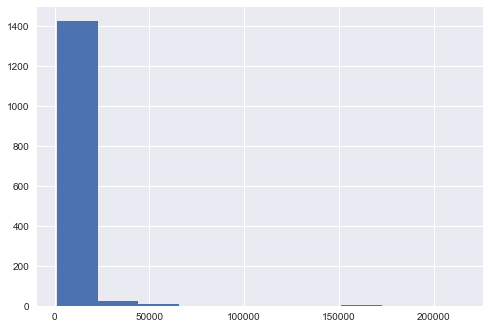

In [111]:
df_housing["LotArea"].hist();

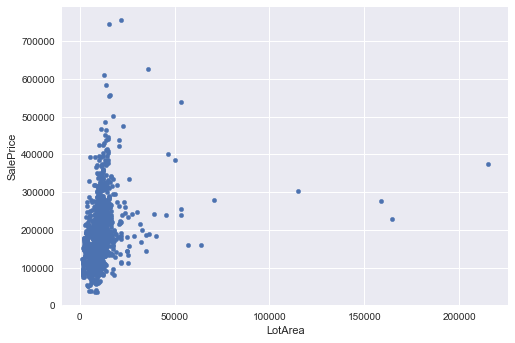

In [112]:
df_housing.plot.scatter(x="LotArea", y="SalePrice");

- Ok, it looks like we have some outliers on our hands!
- Are these outliers a problem?
- Let's look at the scaled version of `LotArea`:

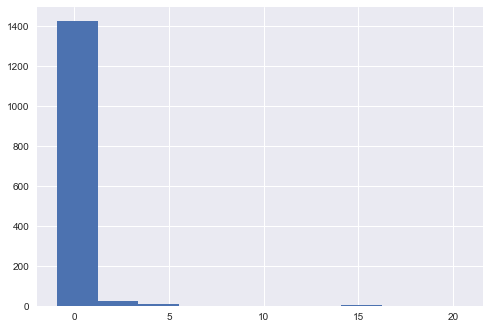

In [113]:
sc = StandardScaler()

area_transformed = sc.fit_transform(df_housing[["LotArea"]])
plt.hist(area_transformed);

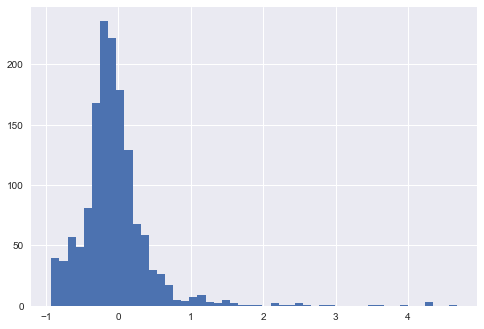

In [114]:
plt.hist(area_transformed[area_transformed < 5], bins=50);

What's happening here is that most of the points are between $-1$ and $1$, but then we have those outliers that are around 20:

In [115]:
area_transformed.max()

20.51827315777325

That is, 20 standard deviations above the mean!

In [116]:
sc.mean_

array([10516.82808219])

In [118]:
np.sqrt(sc.var_)

array([9977.84610545])

Question: what would these values have been without the outliers?

In [119]:
df_housing["LotArea"].mean()

10516.828082191782

In [120]:
df_housing["LotArea"].std()

9981.264932379147

In [121]:
df_housing["LotArea"][df_housing["LotArea"] < 100_000].mean()

10096.507554945056

In [122]:
df_housing["LotArea"][df_housing["LotArea"] < 100_000].std()

5648.81197885462

What about `MinMaxScaler`?

In [123]:
mm = MinMaxScaler()
area_transformed_mm = mm.fit_transform(df_housing[["LotArea"]])

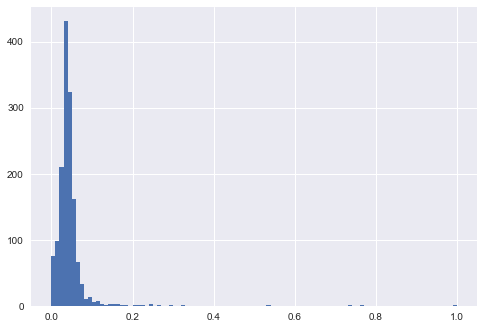

In [124]:
plt.hist(area_transformed_mm, bins=100);

In [125]:
np.percentile(area_transformed_mm, 95)

0.07525836079366192

- The values are supposed to be squished between 0 and 1, but actually 95% of the values are less that 0.075! 
- Question: Why would this be an issue?

<br><br><br><br><br><br>

Because some methods rely on different columns having the same "scale".

- A great comparison of scalers in the presence of outliers can be found [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py).
- Here are a couple scalers they mention:

In [126]:
rb = RobustScaler()
area_transformed_rb = rb.fit_transform(df_housing[["LotArea"]])

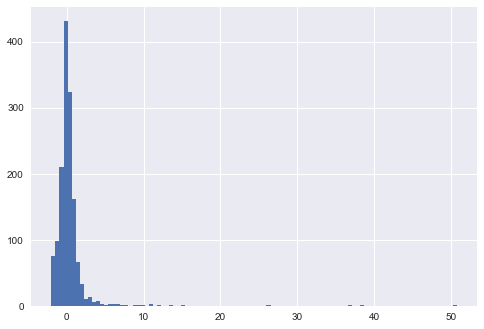

In [127]:
plt.hist(area_transformed_rb, bins=100);

In [128]:
qt = QuantileTransformer()
area_transformed_qt = qt.fit_transform(df_housing[["LotArea"]])

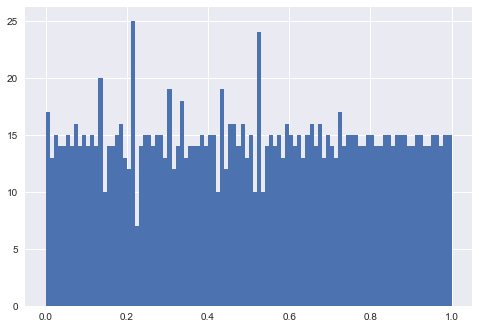

In [129]:
plt.hist(area_transformed_qt, bins=100);

- This transformer gives you a uniform distribution as its output. 
- It basically looks at the _order_ of the values, instead of the values themselves.
- Thus it doesn't care if your outlier is 1 million sq ft or 1 billion sq ft.

# TODO: 

try setting one feature value to a huge number and show that the transformation is unchanged.

## Mean vs. medians (5 min)

I create a small list of numbers:

In [140]:
x = [1,2,3,4,5,6,7,8,99999]

Let's look at these summary statistics:

In [141]:
np.mean(x)

11115.0

In [142]:
np.median(x)

5.0

In [143]:
np.std(x)

31425.23964374284

In [144]:
np.percentile(x, 75) - np.percentile(x, 25)

4.0

What happens if we change the 9 to 99? Or 99999?

- Because of this effect we say the median is more robust than the mean.
- That is why, for imputation, I tended to choose the median value as "typical".

## Break (5 min)

## Effect on trained models (15 min)

In [145]:
from load_process_data import load_housing

In [146]:
X_train_enc, X_valid_enc, X_test_enc, y_train, y_valid, y_test = load_housing()

In [147]:
X_train_enc.head()

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
1341    -0.165978  0.338699    -0.062802    -0.505587   1.048406   
459     -0.026237 -0.354633    -0.764983    -1.415471  -0.731683   
367      1.464330 -0.133037    -0.062802    -0.505587  -0.328644   
894     -0.259139 -0.354322    -0.764983    -0.505587   0.242328   
672     -0.026237  0.084927    -0.062802     0.404297   0.175155   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  \
1341      0.927764   -0.577947    0.791412   -0.284437  -0.622612  ...   
459      -1.679272    0.294327   -0.544487   -0.284437  -0.120404  ...   
367      -1.099931    1.074497   -0.149451   -0.284437   0.336963  ...   
894      -0.279197   -0.577947   -0.937398   -0.284437  -1.295212  ...   
672      -0.375754   -0.577947    0.691592   -0.284437  -0.306490  ...   

      Functional_Maj2  Functional_Min1  Functional_Min2  Functional_Mod  \
1341              0.0              0.0              0.0             0.0   
459               0.0              0.0              0.0             0.0   
367               0.0              0.0              0.0             0.0   
894               0.0              0.0              0.0             0.0   
672               0.0              0.0              0.0             0.0   

      Functional_Typ  Fence_?  Fence_GdPrv  Fence_GdWo  Fence_MnPrv  \
1341             1.0      1.0          0.0         0.0          0.0   
459              1.0      1.0          0.0         0.0          0.0   
367              1.0      1.0          0.0         0.0          0.0   
894              1.0      1.0          0.0         0.0          0.0   
672              1.0      1.0          0.0         0.0          0.0   

      Fence_MnWw  
1341         0.0  
459          0.0  
367          0.0  
894          0.0  
672          0.0  

[5 rows x 288 columns]

In [148]:
lr = Ridge(alpha=100)
lr.fit(X_train_enc, y_train);

In [149]:
lr.score(X_valid_enc, y_valid)

0.8821788300729783

In [150]:
lr_coefs = pd.DataFrame(data=lr.coef_, index=X_train_enc.columns, columns=["Coefficient"])
lr_coefs.loc["LotArea"]

Coefficient    3051.529458
Name: LotArea, dtype: float64

In [151]:
X_train_enc["LotArea"].max()

21.258031501346917

In [152]:
ind = X_train_enc["LotArea"].argmax()
ind

476

How does our model predict on that property with huge `LotArea`?

In [153]:
lr.predict(X_train_enc)[ind]

321041.47149208566

In [154]:
y_train.iloc[ind]

375000

There are two issues to consider here:

1. How does the outlier in the _training_ data change the trained model (i.e. coefficients) - `fit()`
2. How does the outlier in the _test_ data affect predictions on that example - `predict()`

The 2nd issue only pertains to outliers in the features; not the target.


What happens if we make a big outlier in the targets?

In [155]:
len(y_train)

1051

In [156]:
y_train_corrupted = y_train.copy().values
y_train_corrupted[0] = 1_000_000_000 # $1 billion

In [157]:
lr = Ridge(alpha=100)
lr.fit(X_train_enc, y_train_corrupted);

In [158]:
lr_coefs = pd.DataFrame(data=lr.coef_, index=X_train_enc.columns, columns=["Coefficient"])
lr_coefs.loc["LotArea"]

Coefficient    888820.858258
Name: LotArea, dtype: float64

In [159]:
lr_coefs.sort_values(by="Coefficient", ascending=False)

Coefficient
Condition1_RRAe       8.428847e+06
Neighborhood_SawyerW  6.227651e+06
MoSold_7              3.441187e+06
GarageType_Detchd     2.487435e+06
YearBuilt             1.885918e+06
...                            ...
GarageType_Attchd    -1.893091e+06
Neighborhood_CollgCr -2.173065e+06
FullBath             -2.202983e+06
ExterQual            -2.780173e+06
Condition1_Norm      -4.702683e+06

[288 rows x 1 columns]

# TODO

- also show a synthetic corrupted case for a feature value
- if we set `LotArea` for example 0 to 1_000_000_000, does that cause the same magnitude of disaster?

In [160]:
lr.predict(X_train_enc)[ind]

13156289.827060016

In [161]:
y_train_corrupted[ind]

375000

In [162]:
y_train.iloc[ind]

375000

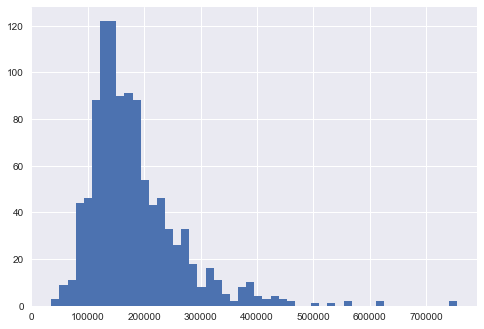

In [165]:
y_train.hist(bins=50);

- This is _not_ the corrupted training example! 
- This crazy prediction is happening for a _different_ training example.

In [163]:
lr.predict(X_train_enc)[0]

47337028.05357513

# TODO

- discuss what happens if you log transform
- in that case, a billion $ might be fine but what about very low values in that case?

Yikes!! What about a random forest?

In [166]:
rf = RandomForestRegressor(max_depth=20, n_estimators=20)
rf.fit(X_train_enc, y_train_corrupted);

In [167]:
rf.predict(X_train_enc)[ind]

311637.95

In [168]:
y_train.iloc[ind]

375000

But what about the prediction on the corrupted point itself:

In [169]:
rf.predict(X_train_enc)[0]

500074285.0

In [170]:
y_train_corrupted[0]

1000000000

In [171]:
train_predictions = rf.predict(X_train_enc)

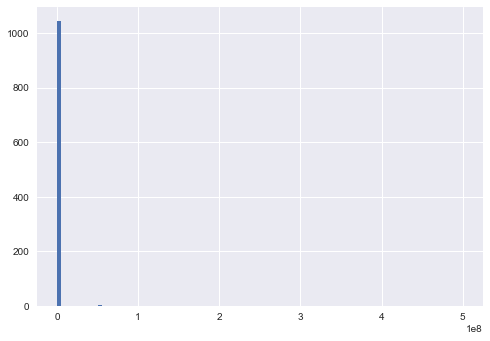

In [172]:
plt.hist(train_predictions, bins=100);

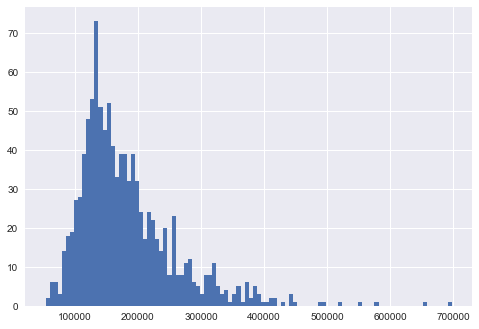

In [173]:
plt.hist(train_predictions[train_predictions < 1e6], bins=100);

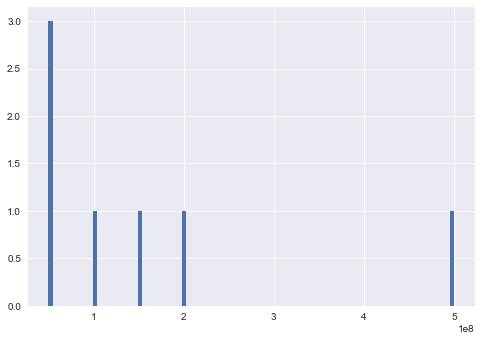

In [174]:
plt.hist(train_predictions[train_predictions > 1e6], bins=100);

# TODO

- make these histograms for the Ridge 
- we'd see crazy values

- So, we get 10ish crazy predictions (presumably, cases with similar features to the corrupted data point). 
- We can compare this with a random forest trained on the original training data:

In [175]:
rf_uncorrupted = RandomForestRegressor(max_depth=20, n_estimators=20)
rf_uncorrupted.fit(X_train_enc, y_train);

In [176]:
train_predictions_unc = rf_uncorrupted.predict(X_train_enc)

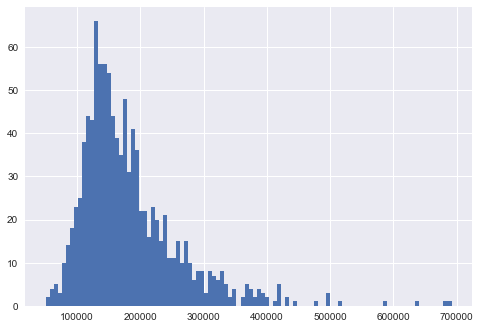

In [177]:
plt.hist(train_predictions_unc, bins=100);

- The linear regression suffered a lot more because the coefficients affect all predictions.
- There are ways around this, e.g. sklearn's [HuberRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html) is like Ridge but robust to outliers **in the targets**.
  - It even tells you the outliers afterward!
- Earlier I said always use `Ridge` over `LinearRegression`.
- So, always use `HuberRegressor` over `Ridge`?
  - As far as the model itself is concerned, yes. 
  - When there are no outliers, `HuberRegressor` will behave about the same as `Ridge.`
  - However, I wouldn't make as strong of a statement this time.
  - The reason is computational reasons - the way `fit()` works with `HuberRegressor` is different, and could be slower.
  - But sure, just to be a bit controversial, let me say always use `Ridge` over `LinearRegression` and always use `HuberRegressor` over `Ridge`.

In [178]:
from sklearn.linear_model import HuberRegressor

In [179]:
hr = HuberRegressor(max_iter=1000)
hr.fit(X_train_enc, y_train_corrupted);

In [180]:
hr_coefs = pd.DataFrame(data=hr.coef_, index=X_train_enc.columns, columns=["Coefficient"])
hr_coefs.loc["LotArea"]

Coefficient    5937.904251
Name: LotArea, dtype: float64

In [181]:
hr_coefs.sort_values(by="Coefficient", ascending=False)

Coefficient
Neighborhood_StoneBr  32146.927925
RoofMatl_WdShngl      25792.989823
Neighborhood_NridgHt  22291.660878
Street_Pave           17318.187863
GrLivArea             16500.602551
...                            ...
Street_Grvl          -14072.557250
Condition2_PosN      -14573.064356
Neighborhood_Timber  -15639.197360
BedroomAbvGr_5       -16820.804387
Functional_Maj2      -17200.429292

[288 rows x 1 columns]

In [182]:
hr.predict(X_train_enc)[ind]

377414.73470940744

In [183]:
y_train_corrupted[ind]

375000

In [184]:
y_train.iloc[ind]

375000

# TODO

- explicitly talk about why you can't look at one feature at a time.

## Outlier detection with clustering (0 min)

- No time to cover this in detail, it's a TODO for next term.
- But, you are asked to think about this in the last part of hw7.

## Supervised outlier detection (0 min)

#### Credit card fraud data (lecture 8)

In [185]:
df_credit = pd.read_csv('data/creditcard.csv', encoding='latin-1')
df_credit.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

- We looked at this dataset for another reason, but this is really an anomaly detection problem!

## Outlier scenarios (5 min)

- Outliers are not always "bad".
- Remember when we talked about unbalanced training sets?
- We needed to ask ourselves two important questions:
  1. Are the deployment data and the training data coming from the same "distribution"?
  2. What types of mistakes are we most worried about?
   

#### House price example

Train vs. deploy? There are a few cases:

1. Train/deploy same distribution
  - the same software bug for recording `LotArea` will affect both train/test and deployment.
2. Outliers only in training data
  - the buggy software is only used to collect training data; or, the buggy software only affects our measurements of our target (house price)
3. Outliers only in deployment features
  - the training set is fine, but in deployment 

What do we care about? There are also cases:

1. We don't care about outliers (they are "mistakes" or we just don't care about predicting well on them)
  - software bug corrupted the `LotArea` for certain properties
  - we want to remove these
2. We want to predict correctly on outliers (they are "real data")
  - some properties genuinely have a huge `LotArea` and we want to predict well on such cases in deployment


#### This sounds like a huge mess, what should I do??
 
- Keep in mind that outliers are a tricky problem.
- Think carefully about how you want to treat outliers. 
- If they are "bad outliers"
  - Consider methods that are insensitive to outliers (e.g. Huber regression)
  - Consider explicitly finding and removing the outliers (e.g. via EDA)
- (Usually) Trust your validation/test scores, but not always!

## Summary (5 min)

- Outliers are everywhere
- Outliers are often undesireable, but not always!
- There are several ways of detecting outliers.
  - Visually
  - Clustering
  - Supervised learning (if labels are available)
  - Other approaches (see [CPSC 340 slides](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L10.pdf))
- Different summary statistics behave differently w.r.t. outliers
  - e.g. mean vs. median
- Different preprocessing methods behave differently w.r.t. outliers
  - e.g. `MinMaxScaler`
- Different models behave different w.r.t. outliers
  - e.g. `Ridge` vs. `HuberRegressor` or `RandomForestRegressor`
- One should carefully consider where the outliers might be occurring:
  - Train vs. deploy
  - X vs. y

## True/False questions (15 min)

1. Outliers in the target values are not an issue for classification problems.
2. Outliers in the target values are not an issue in the deployment phrase.
3. Some outliers cannot be detected by looking at the individual feature histograms.
4. Consider the case of one big outlier in a feature vs. many rows with that unusually large/small value. `StandardScaler` behaves the same in both cases.
5. Consider the case of one big outlier in a feature vs. many rows with that unusually large/small value. `MinMaxScaler` behaves the same in both cases.